In [74]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import seaborn as sns
from wordcloud import WordCloud
import logging
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, Model
import networkx as nx
from sklearn.neighbors import NearestNeighbors

In [2]:
!pip install mediapipe

In [3]:
import mediapipe as  mp

In [4]:
train = pd.read_csv("/kaggle/input/asl-citizen/ASL_Citizen/splits/train.csv")
test = pd.read_csv("/kaggle/input/asl-citizen/ASL_Citizen/splits/test.csv")
val = pd.read_csv("/kaggle/input/asl-citizen/ASL_Citizen/splits/val.csv")

In [5]:
train.rename(columns={'Participant ID' : 'p_id',
                   'Video file': 'video_id',
                   'Gloss' : 'gloss',
                   'ASL-LEX Code' : 'code'
                  }, inplace=True)

test.rename(columns={'Participant ID' : 'p_id',
                   'Video file': 'video_id',
                   'Gloss' : 'gloss',
                   'ASL-LEX Code' : 'code'
                  }, inplace=True)

val.rename(columns={'Participant ID' : 'p_id',
                   'Video file': 'video_id',
                   'Gloss' : 'gloss',
                   'ASL-LEX Code' : 'code'
                  }, inplace=True)

In [6]:
combined_df = pd.concat([train, test, val]).reset_index(drop=True)
gloss_counts = combined_df['gloss'].value_counts()
gloss_counts

gloss
DOG1           45
BASKETBALL1    44
WHATFOR1       43
BELT1          40
PARTY1         39
               ..
DEMAND2        22
GUESS2         22
SHAVE2         22
LETTUCE2       21
BEE2           21
Name: count, Length: 2731, dtype: int64

In [7]:
selected_glosses = gloss_counts[gloss_counts >= 39].index
selected_glosses.size

23

In [8]:
filtered_videos = combined_df[combined_df['gloss'].isin(selected_glosses)]

In [9]:
subset_size = min(len(filtered_videos), 900) 
subset_videos = filtered_videos.sample(n=subset_size, random_state=42).reset_index(drop=True)
subset_size

900

In [10]:
train_sub, temp_sub = train_test_split(subset_videos, test_size=0.3, random_state=42)
test_sub, val_sub = train_test_split(temp_sub, test_size=1/3, random_state=42)

In [11]:
print("trainig sub set has : ", train_sub.shape[0], " rows")
print("val sub set has : ", val_sub.shape[0], " rows")
print("testing sub set has : ", test_sub.shape[0], " rows")

trainig sub set has :  630  rows
val sub set has :  90  rows
testing sub set has :  180  rows


In [12]:
print("Training Set Distribution:\n", train_sub['gloss'].value_counts())
print("\nTesting Set Distribution:\n", test_sub['gloss'].value_counts())
print("\nValidation Set Distribution:\n", val_sub['gloss'].value_counts())

Training Set Distribution:
 gloss
DOG1             33
BITE1            33
BASKETBALL1      31
DEAF1            30
PARTY1           30
DARK1            30
BEE1             30
FOREIGNER1       29
SHAVE1           29
HOSPITAL1        28
PATIENT2         28
ROCKINGCHAIR1    27
MECHANIC1        27
WHATFOR1         27
BELT1            26
FINE1            26
NIGHT1           26
CHRISTMAS1       26
BREAKFAST1       24
DEMAND1          24
MOVIE1           23
EAT1             22
ELEVATOR1        21
Name: count, dtype: int64

Testing Set Distribution:
 gloss
BREAKFAST1       12
ELEVATOR1        11
MOVIE1           11
EAT1             10
DOG1             10
BASKETBALL1      10
WHATFOR1         10
ROCKINGCHAIR1     9
BELT1             9
FINE1             9
HOSPITAL1         8
NIGHT1            8
DEAF1             8
MECHANIC1         8
DEMAND1           7
BEE1              6
FOREIGNER1        6
BITE1             6
SHAVE1            5
PARTY1            5
DARK1             4
CHRISTMAS1        4
PATIEN

In [13]:
# import pandas as pd

# pd.set_option('display.max_rows', None)
# print(df['Gloss'].value_counts())
# pd.reset_option('display.max_rows') # It's good practice to reset the option afterwards

In [14]:
#### REQUIRED
base_path = '/kaggle/input/asl-citizen/ASL_Citizen'
video_dir = os.path.join(base_path, 'videos')
splits_dir = os.path.join(base_path, 'splits')

In [15]:
seed=random.seed(1024)
print(random.randint(7,12))

7


In [16]:
test_small = pd.read_csv("/kaggle/input/smallsets/test_small.csv")
train_small = pd.read_csv("/kaggle/input/smallsets/train_small.csv")
val_small = pd.read_csv("/kaggle/input/smallsets/val_small.csv")

In [17]:
train_small.columns

Index(['p_id', 'video_id', 'gloss', 'code'], dtype='object')

# Defining Gloabal Variable

In [18]:
NUM_FRAMES = 10
KNN_NEIGHBORS = 5
NUM_KEYPOINTS = 42

In [19]:
pip show mediapipe

Name: mediapipe
Version: 0.10.21
Summary: MediaPipe is the simplest way for researchers and developers to build world-class ML solutions and applications for mobile, edge, cloud and the web.
Home-page: https://github.com/google/mediapipe
Author: The MediaPipe Authors
Author-email: mediapipe@google.com
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, attrs, flatbuffers, jax, jaxlib, matplotlib, numpy, opencv-contrib-python, protobuf, sentencepiece, sounddevice
Required-by: 
Note: you may need to restart the kernel to use updated packages.


# frame extraction

In [20]:
from sklearn.cluster import KMeans
import numpy as np
import cv2
import os
import pandas as pd
from tqdm import tqdm
import mediapipe as mp


mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.1)


def get_keypoints(frame):
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    hand_results = hands.process(frame_rgb) 
    keypoints = np.zeros((42 * 3,))
    
    if hand_results.multi_hand_landmarks:
        for i, hand_landmarks in enumerate(hand_results.multi_hand_landmarks[:2]): 
            for j, lm in enumerate(hand_landmarks.landmark):
                keypoints[i * 21 * 3 + j * 3:i * 21 * 3 + j * 3 + 3] = [lm.x, lm.y, lm.z]
    
    return keypoints
    

def extract_keypoint_frames(video_path, target_frames=10):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return None, None, f"Failed to open {video_path}"

    all_frames = []
    all_keypoints = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret or frame is None or frame.size == 0:
            break

        if len(frame.shape) == 2:
            frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)

        frame = cv2.resize(frame, (224, 224))
        all_frames.append(frame)
        all_keypoints.append(get_keypoints(frame))
    cap.release()

    total_frames = len(all_frames)
    if total_frames == 0:
        return None, None, f"No frames extracted from {video_path}"

    all_keypoints = np.array(all_keypoints)

    
    unique_keypoints = np.unique(all_keypoints, axis=0)
    
    
    if unique_keypoints.shape[0] < target_frames or total_frames < target_frames:
        selected_indices = np.linspace(0, total_frames - 1, num=target_frames, dtype=int)
    else:
        try:
            kmeans = KMeans(n_clusters=target_frames, random_state=42, n_init=10)
            kmeans.fit(all_keypoints)
            cluster_indices = kmeans.labels_

            key_indices = []
            for cluster in range(target_frames):
                cluster_frame_indices = np.where(cluster_indices == cluster)[0]
                if len(cluster_frame_indices) > 0:
                    key_indices.append(cluster_frame_indices[0])

            # If fewer clusters formed fill in missing
            if len(key_indices) < target_frames:
                remaining_indices = list(set(range(total_frames)) - set(key_indices))
                fill_indices = np.linspace(0, len(remaining_indices) - 1, num=target_frames - len(key_indices), dtype=int)
                key_indices += [remaining_indices[i] for i in fill_indices]

            selected_indices = sorted(key_indices[:target_frames])
        except:
            
            selected_indices = np.linspace(0, total_frames - 1, num=target_frames, dtype=int)

    key_frames = [all_frames[i] for i in selected_indices]
    key_keypoints = all_keypoints[selected_indices]

    return np.array(key_frames), key_keypoints, None


def process_videos(subset, video_dir, output_dir, target_frames=10):
    processed_data = {}

    for idx, row in tqdm(subset.iterrows(), total=len(subset)):
        video_id = row['video_id']
        gloss = row.get('gloss', 'Unknown')
        video_path = os.path.join(video_dir, video_id)

        key_frames, key_keypoints, error = extract_keypoint_frames(video_path, target_frames=target_frames)
        if error:
            print("got error", error)
            continue

        frame_path = os.path.join(output_dir, f"{video_id}_keyframes.npy")
        keypoint_path = os.path.join(output_dir, f"{video_id}_keypoints.npy")
        np.save(frame_path, key_frames)
        np.save(keypoint_path, key_keypoints)

        processed_data[video_id] = {
            'gloss': gloss,
            'frame_count': len(key_frames),
            'frame_path': frame_path,
            'keypoint_path': keypoint_path
        }
        
    metadata_df = pd.DataFrame.from_dict(processed_data, orient='index')
    return metadata_df

In [21]:
gloss_to_label = {
        "DOG1": 0, "BITE1": 1, "BASKETBALL1": 2, "DEAF1": 3, "PARTY1": 4,
        "DARK1": 5, "BEE1": 6, "FOREIGNER1": 7, "SHAVE1": 8, "HOSPITAL1": 9
    }

In [22]:
train_selected=train_small[train_small["gloss"].isin(list(gloss_to_label.keys()))]
test_selected=test_small[test_small["gloss"].isin(list(gloss_to_label.keys()))]
val_selected=val_small[val_small["gloss"].isin(list(gloss_to_label.keys()))]

In [23]:
output_dir = "/kaggle/working/extracted_keypoints"
os.makedirs(output_dir, exist_ok=True)

In [24]:
train_metadata = process_videos(train_sub, video_dir, output_dir, target_frames=NUM_FRAMES)
val_metadata = process_videos(val_sub, video_dir, output_dir, target_frames=NUM_FRAMES)
test_metadata = process_videos(test_sub, video_dir, output_dir, target_frames=NUM_FRAMES)

100%|██████████| 180/180 [09:20<00:00,  3.11s/it]


In [30]:
val_selected

,p_id,video_id,gloss,code
0,P46,3250233036968666-DOG.mp4,DOG1,A_01_056
1,P18,9692444989436564-DOG.mp4,DOG1,A_01_056
2,P37,8615822021106332-DOG.mp4,DOG1,A_01_056
3,P15,7432967051023693-BITE.mp4,BITE1,K_02_045
4,P42,45986851425089204-BITE.mp4,BITE1,K_02_045
5,P40,9595255203933857-BITE.mp4,BITE1,K_02_045
6,P15,4747623892063422-BASKETBALL.mp4,BASKETBALL1,A_03_045
7,P52,9432574110287932-seedBASKETBALL.mp4,BASKETBALL1,A_03_045
8,P42,7322377994548119-DEAF.mp4,DEAF1,F_03_038
9,P18,14415908988995363-DEAF.mp4,DEAF1,F_03_038


In [31]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

def visualize_keypoints(frames, keypoints_seq, save_path=None):
    num_frames = len(frames)
    cols = min(5, num_frames)
    rows = (num_frames + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))

    for i, (frame, keypoints) in enumerate(zip(frames, keypoints_seq)):
        ax = axes[i // cols, i % cols] if rows > 1 else axes[i % cols]
        frame_copy = frame.copy()
        h, w, _ = frame_copy.shape

        keypoints = keypoints.reshape(-1, 3)

        for x, y, z in keypoints:
            if not np.isnan(x) and not np.isnan(y) and 0 <= x <= 1 and 0 <= y <= 1:
                cx, cy = int(x * w), int(y * h)
                cv2.c

        ax.imshow(cv2.cvtColor(frame_copy, cv2.COLOR_BGR2RGB))
        ax.axis("off")

        if save_path:
            cv2.imwrite(os.path.join(save_path, f"frame_{i}.jpg"), frame_copy)

    for j in range(i + 1, rows * cols):
        fig.delaxes(axes.flatten()[j])

    plt.tight_layout()
    plt.show()

In [32]:
train_small[50:70]

,p_id,video_id,gloss,code
50,P51,8911332562413585-PARTY.mp4,PARTY1,G_02_059
51,P12,878457250310533-PARTY.mp4,PARTY1,G_02_059
52,P30,4044296872971618-PARTY.mp4,PARTY1,G_02_059
53,P11,26521170494987056-PARTY.mp4,PARTY1,G_02_059
54,P42,5215173009286387-PARTY.mp4,PARTY1,G_02_059
55,P37,10722954174527533-DARK.mp4,DARK1,J_03_094
56,P40,0525121513125173-DARK.mp4,DARK1,J_03_094
57,P47,6733132641220483-DARK.mp4,DARK1,J_03_094
58,P18,0347681952564558-DARK.mp4,DARK1,J_03_094
59,P6,0224524746429009-DARK.mp4,DARK1,J_03_094


AttributeError: module 'cv2' has no attribute 'c'

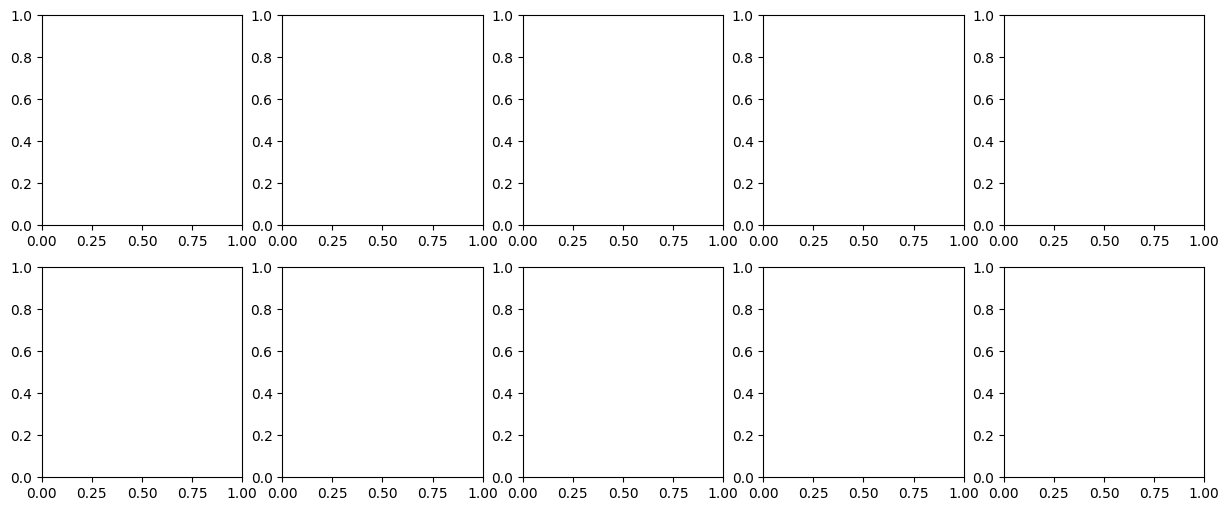

In [35]:
# video_path = "/kaggle/input/asl-citizen/ASL_Citizen/videos/26521170494987056-PARTY.mp4"
# key_frames, key_keypoints, error = process_video(video_path)
# if error:
#     print("Error:", error)
# else:
#     visualize_keypoints(key_frames, key_keypoints)

frames = np.load(train_metadata.iloc[1]['frame_path'])
keypoints = np.load(train_metadata.iloc[1]['keypoint_path'])

visualize_keypoints(frames, keypoints)

In [36]:
train_metadata

,gloss,frame_count,frame_path,keypoint_path
051718892767815605-MECHANIC.mp4,MECHANIC1,10,/kaggle/working/extracted_keypoints/0517188927...,/kaggle/working/extracted_keypoints/0517188927...
6491857817064066-PATIENT 2.mp4,PATIENT2,10,/kaggle/working/extracted_keypoints/6491857817...,/kaggle/working/extracted_keypoints/6491857817...
9789286217696351-NIGHT.mp4,NIGHT1,10,/kaggle/working/extracted_keypoints/9789286217...,/kaggle/working/extracted_keypoints/9789286217...
6813035797502778-ELEVATOR.mp4,ELEVATOR1,10,/kaggle/working/extracted_keypoints/6813035797...,/kaggle/working/extracted_keypoints/6813035797...
5021140202543803-FOREIGNER.mp4,FOREIGNER1,10,/kaggle/working/extracted_keypoints/5021140202...,/kaggle/working/extracted_keypoints/5021140202...
...,...,...,...,...
7910128481289247-EAT.mp4,EAT1,10,/kaggle/working/extracted_keypoints/7910128481...,/kaggle/working/extracted_keypoints/7910128481...
36318193518975583-ELEVATOR.mp4,ELEVATOR1,10,/kaggle/working/extracted_keypoints/3631819351...,/kaggle/working/extracted_keypoints/3631819351...
2838376949179944-MOVIE.mp4,MOVIE1,10,/kaggle/working/extracted_keypoints/2838376949...,/kaggle/working/extracted_keypoints/2838376949...
31395737777791566-BEE.mp4,BEE1,10,/kaggle/working/extracted_keypoints/3139573777...,/kaggle/working/extracted_keypoints/3139573777...


# Reshaping keypoints

In [37]:
def reshape_and_save_keypoints(metadata):
    for path in metadata["keypoint_path"]:
        keypoints = np.load(path)  # Load keypoints from .npy file
        reshaped_keypoints = keypoints.reshape(NUM_FRAMES, 42, 3)  # Reshape to (num_frames, 42, 3)
        np.save(path, reshaped_keypoints)  # Overwrite original file

In [38]:
reshape_and_save_keypoints(test_metadata)
reshape_and_save_keypoints(train_metadata)
reshape_and_save_keypoints(val_metadata)

In [39]:
samp = np.load(test_metadata['keypoint_path'][5])
samp.shape

<ipython-input-39-59f32f56a9d5>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  samp = np.load(test_metadata['keypoint_path'][5])


(10, 42, 3)

In [40]:
!pip install torch torchvision torchaudio
!pip install torch-geometric
!pip install sru

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.9 MB/s eta 0:00:0000:01


# Spatial Graphs creation

In [41]:
# HAND_CONNECTIONS = [
#     (0, 1), (1, 2), (2, 3), (3, 4),      # Thumb
#     (0, 5), (5, 6), (6, 7), (7, 8),      # Index
#     (0, 9), (9,10), (10,11), (11,12),    # Middle
#     (0,13), (13,14), (14,15), (15,16),   # Ring
#     (0,17), (17,18), (18,19), (19,20)    # Pinky
# ]

hand_edges = [
    (0, 1), (1, 2), (2, 3), (3, 4),       # Thumb
    (0, 5), (5, 6), (6, 7), (7, 8),       # Index
    (5, 9), (9, 10), (10, 11), (11, 12),  # Middle
    (9, 13), (13, 14), (14, 15), (15, 16),# Ring
    (13, 17), (17, 18), (18, 19), (19, 20)# Pinky
]

edges = hand_edges.copy()
edges += [(i+21, j+21) for i, j in hand_edges]

In [42]:
import torch
from torch_geometric.data import Data

def get_hand_edges(offset=0):
    fingers = [
        [0, 1, 2, 3, 4],        # Thumb
        [0, 5, 6, 7, 8],        # Index
        [0, 9,10,11,12],        # Middle
        [0,13,14,15,16],        # Ring
        [0,17,18,19,20],        # Pinky
    ]
    edges = []
    for finger in fingers:
        edges += [[finger[i] + offset, finger[i+1] + offset] for i in range(len(finger)-1)]
    return edges

def get_full_edges():
    left = get_hand_edges(0)
    right = get_hand_edges(21)
    return left + right

def create_spatial_graph_from_frame(keypoints_42x3):
    keypoints_tensor = torch.tensor(keypoints_42x3, dtype=torch.float32)
    edge_index = torch.tensor(get_full_edges(), dtype=torch.long).t().contiguous()
    return Data(x=keypoints_tensor, edge_index=edge_index)


In [43]:
def create_graph_sequence_from_video(keypoints_video):
    graph_sequence = []
    for t in range(len(keypoints_video)):
        frame_graph = create_spatial_graph_from_frame(keypoints_video[t])
        graph_sequence.append(frame_graph)
    return graph_sequence

In [44]:
sample = train_metadata.iloc[0] 
keypoints = np.load(sample['keypoint_path'])
graph_sequence = create_graph_sequence_from_video(keypoints)

print(f"Generated {len(graph_sequence)} graphs")
print("Sample graph:")
print(graph_sequence[0])

Generated 10 graphs
Sample graph:
Data(x=[42, 3], edge_index=[2, 40])


In [45]:
import matplotlib.pyplot as plt

def plot_graph_sequence_on_frames(frames, keypoints_seq, graph_seq, num_frames=NUM_FRAMES):
    fig, axs = plt.subplots(2, 5, figsize=(20, 8))
    axs = axs.flatten()

    for idx in range(num_frames):
        frame = frames[idx]
        keypoints = keypoints_seq[idx]
        graph = graph_seq[idx]
        edge_index = graph.edge_index

        axs[idx].imshow(frame)
        axs[idx].axis("off")
        axs[idx].set_title(f"Frame {idx}")

        # nodes
        for i, (x, y, _) in enumerate(keypoints):
            cx, cy = int(x * frame.shape[1]), int(y * frame.shape[0])
            axs[idx].scatter(cx, cy, c='lime', s=20)

        # edges
        for j in range(edge_index.shape[1]):
            i, k = edge_index[:, j]
            x1, y1, _ = keypoints[i]
            x2, y2, _ = keypoints[k]
            cx1, cy1 = int(x1 * frame.shape[1]), int(y1 * frame.shape[0])
            cx2, cy2 = int(x2 * frame.shape[1]), int(y2 * frame.shape[0])
            axs[idx].plot([cx1, cx2], [cy1, cy2], c='cyan', linewidth=1)

    plt.tight_layout()
    plt.show()

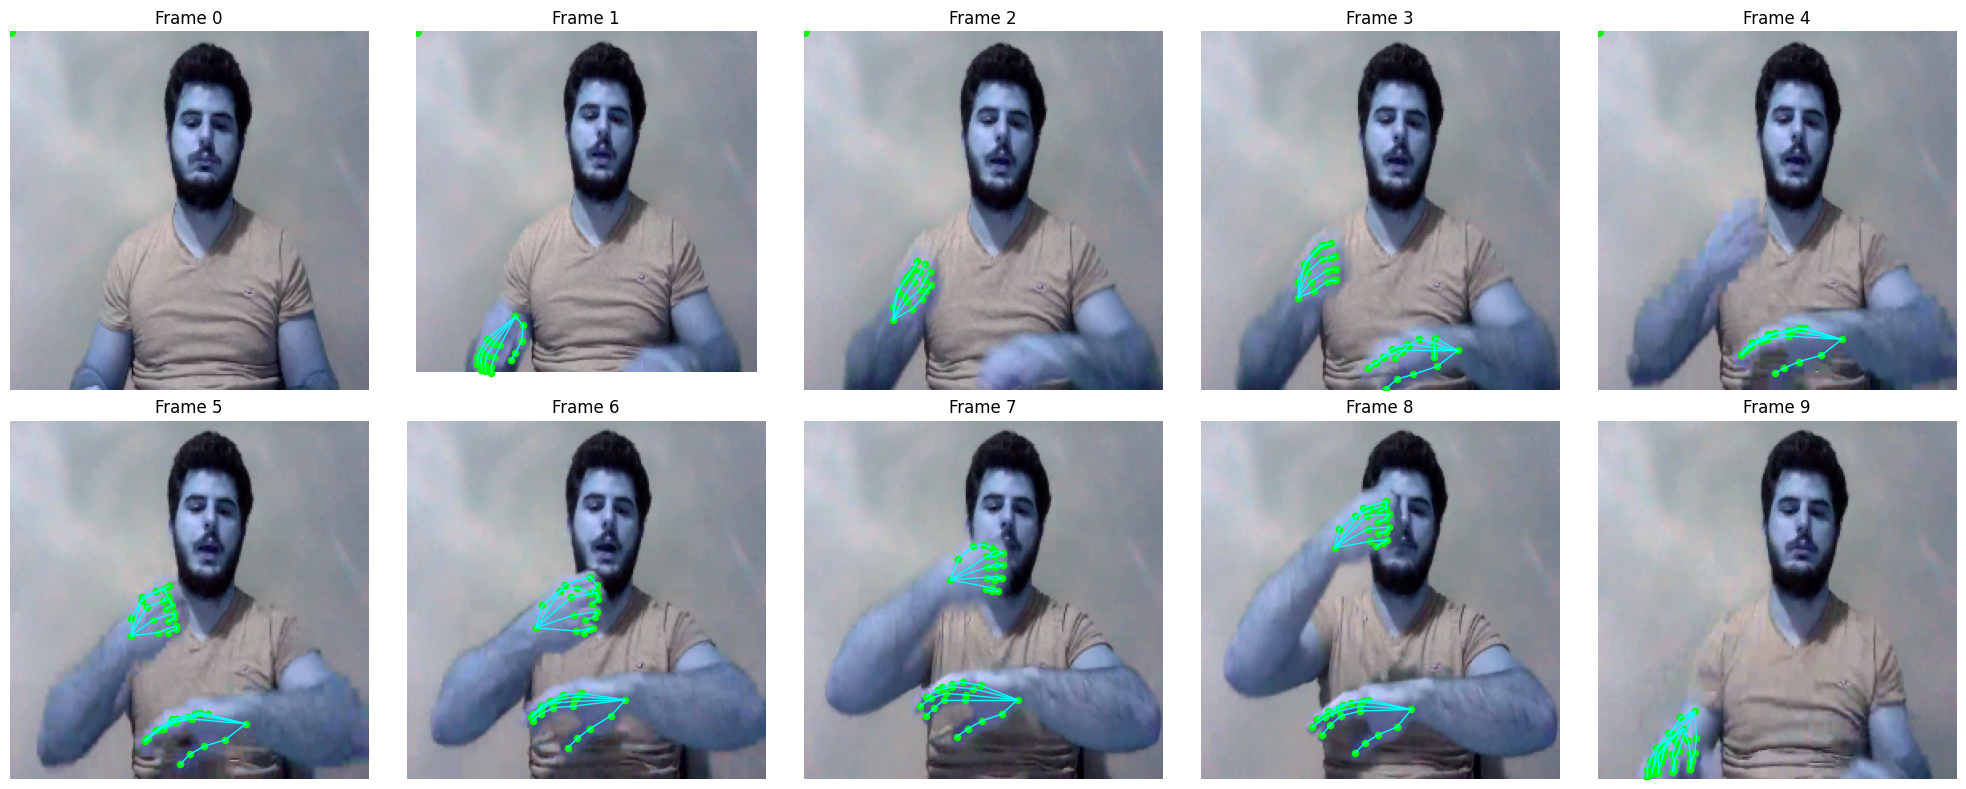

In [46]:
sample = train_metadata.iloc[3]
keypoints_seq = np.load(sample['keypoint_path'])  
frames = np.load(sample['frame_path']) 

graph_seq = create_graph_sequence_from_video(keypoints_seq)

plot_graph_sequence_on_frames(frames, keypoints_seq, graph_seq, num_frames=NUM_FRAMES)


# Encoding Glosses

In [47]:
def assign_numeric_labels(train_df, val_df, test_df):
    all_glosses = sorted(train_df['gloss'].unique())
    gloss_to_label = {gloss: idx for idx, gloss in enumerate(all_glosses)}
    label_to_gloss = {idx: gloss for gloss, idx in gloss_to_label.items()}

    train_df['label'] = train_df['gloss'].map(gloss_to_label)
    val_df['label'] = val_df['gloss'].map(gloss_to_label)
    test_df['label'] = test_df['gloss'].map(gloss_to_label)

    return gloss_to_label, label_to_gloss

In [48]:
gloss_to_label, label_to_gloss = assign_numeric_labels(train_metadata, val_metadata, test_metadata)
print(gloss_to_label)

{'BASKETBALL1': 0, 'BEE1': 1, 'BELT1': 2, 'BITE1': 3, 'BREAKFAST1': 4, 'CHRISTMAS1': 5, 'DARK1': 6, 'DEAF1': 7, 'DEMAND1': 8, 'DOG1': 9, 'EAT1': 10, 'ELEVATOR1': 11, 'FINE1': 12, 'FOREIGNER1': 13, 'HOSPITAL1': 14, 'MECHANIC1': 15, 'MOVIE1': 16, 'NIGHT1': 17, 'PARTY1': 18, 'PATIENT2': 19, 'ROCKINGCHAIR1': 20, 'SHAVE1': 21, 'WHATFOR1': 22}


In [49]:
def process_subset_to_graph_sequences(subset_df):
    data = []
    for _, row in subset_df.iterrows():
        keypoints_path = row['keypoint_path']
        label = row['label']
        
        keypoints = np.load(keypoints_path)  # shape: (T, 42, 3)
        graph_seq = create_graph_sequence_from_video(keypoints)

        data.append((graph_seq, label))
    return data

In [50]:
train_metadata

,gloss,frame_count,frame_path,keypoint_path,label
051718892767815605-MECHANIC.mp4,MECHANIC1,10,/kaggle/working/extracted_keypoints/0517188927...,/kaggle/working/extracted_keypoints/0517188927...,15
6491857817064066-PATIENT 2.mp4,PATIENT2,10,/kaggle/working/extracted_keypoints/6491857817...,/kaggle/working/extracted_keypoints/6491857817...,19
9789286217696351-NIGHT.mp4,NIGHT1,10,/kaggle/working/extracted_keypoints/9789286217...,/kaggle/working/extracted_keypoints/9789286217...,17
6813035797502778-ELEVATOR.mp4,ELEVATOR1,10,/kaggle/working/extracted_keypoints/6813035797...,/kaggle/working/extracted_keypoints/6813035797...,11
5021140202543803-FOREIGNER.mp4,FOREIGNER1,10,/kaggle/working/extracted_keypoints/5021140202...,/kaggle/working/extracted_keypoints/5021140202...,13
...,...,...,...,...,...
7910128481289247-EAT.mp4,EAT1,10,/kaggle/working/extracted_keypoints/7910128481...,/kaggle/working/extracted_keypoints/7910128481...,10
36318193518975583-ELEVATOR.mp4,ELEVATOR1,10,/kaggle/working/extracted_keypoints/3631819351...,/kaggle/working/extracted_keypoints/3631819351...,11
2838376949179944-MOVIE.mp4,MOVIE1,10,/kaggle/working/extracted_keypoints/2838376949...,/kaggle/working/extracted_keypoints/2838376949...,16
31395737777791566-BEE.mp4,BEE1,10,/kaggle/working/extracted_keypoints/3139573777...,/kaggle/working/extracted_keypoints/3139573777...,1


In [51]:
train_graph_data = process_subset_to_graph_sequences(train_metadata)
val_graph_data = process_subset_to_graph_sequences(val_metadata)
test_graph_data = process_subset_to_graph_sequences(test_metadata)

In [52]:
print(f"Train samples: {len(train_graph_data)}")
print(f"Validation samples: {len(val_graph_data)}")
print(f"Test samples: {len(test_graph_data)}")

Train samples: 630
Validation samples: 90
Test samples: 180


In [53]:

graph_seq, label = train_graph_data[0]
print(f"Graph sequence length (T): {len(graph_seq)}")
print(f"Graph[0] node feature shape: {graph_seq[0].x.shape}")
print(f"Graph[0] edge index shape: {graph_seq[0].edge_index.shape}")
print(f"Label: {label}")

Graph sequence length (T): 10
Graph[0] node feature shape: torch.Size([42, 3])
Graph[0] edge index shape: torch.Size([2, 40])
Label: 15


In [54]:
import torch
from torch.utils.data import Dataset
from torch_geometric.data import Data
import numpy as np

class GestureGraphDataset(Dataset):
    def __init__(self, metadata, num_keypoints=42):
        self.metadata = metadata
        self.num_keypoints = num_keypoints

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        sample = self.metadata.iloc[idx]
        keypoints = np.load(sample['keypoint_path'])  # Shape: (T, 42, 3)
        label = int(sample['label'])  # Integer class label

        graphs = []
        for frame in keypoints:
            x = torch.tensor(frame[:, :2], dtype=torch.float) 
            edge_index = self.get_edge_index(self.num_keypoints)
            graph = Data(x=x, edge_index=edge_index)
            graphs.append(graph)
            
            print("GET ITEM VAL:", label) 
            return graphs, label
   

    def get_edge_index(self, num_nodes):
        edges = []
        for i in range(num_nodes - 1):
            edges.append([i, i + 1])
            edges.append([i + 1, i])  # undirected
        edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
        return edge_index

# Model Definition

In [55]:
import torch
import torch.nn as nn
from torch_geometric.nn import GATConv
from sru import SRU


class SpatialGAT(nn.Module):
    def __init__(self, in_channels=3, hidden_channels=64, out_channels=64):
        super().__init__()
        self.gat1 = GATConv(in_channels, hidden_channels)
        self.gat2 = GATConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.gat1(x, edge_index)
        x = torch.relu(x)
        x = self.gat2(x, edge_index)
        x = torch.relu(x) 
        return x


class GAT_SRUTemporalModel(nn.Module):
    def __init__(self, in_channels=3, spatial_dim=64, temporal_hidden=128, num_classes=10):
        super().__init__()
        self.spatial_gat = SpatialGAT(in_channels, 64, spatial_dim)
        self.temporal_model = SRU(input_size=spatial_dim * 42, hidden_size=temporal_hidden,
                                  num_layers=2, dropout=0.2, bidirectional=False)
        self.classifier = nn.Sequential(
            nn.Linear(temporal_hidden, temporal_hidden // 2),
            nn.ReLU(),
            nn.Dropout(0.3),
        
            nn.Linear(temporal_hidden // 2, temporal_hidden // 4),
            nn.ReLU(),
            nn.Dropout(0.3),
        
            nn.Linear(temporal_hidden // 4, num_classes)
        )


    def forward(self, graph_sequence):
        spatial_features = []
        for graph in graph_sequence:
            features = self.spatial_gat(graph)  # shape: (42, spatial_dim)
            features = features.view(1, -1)     # shape: (1, 42 * spatial_dim)
            spatial_features.append(features)

        x = torch.cat(spatial_features, dim=0).unsqueeze(1)  # (T, 1, 42 * spatial_dim)
        x, _ = self.temporal_model(x)  # (T, 1, temporal_hidden)
        out = self.classifier(x[-1])   # Use final timestep output
        return out

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:1964: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sru/cuda_functional.py:23: UserWarning: Just-in-time loading and compiling the CUDA kernels of SRU was unsuccessful. Got the following error:
list index out of range
  warnings.warn("Just-in-time loading and compiling the CUDA kernels of SRU was unsuccessful. "


In [56]:
model = GAT_SRUTemporalModel(num_classes=len(gloss_to_label))
sample_graph_seq, sample_label = train_graph_data[0]
output = model(sample_graph_seq)

print("Output shape:", output.shape)

Output shape: torch.Size([1, 23])


/usr/local/lib/python3.10/dist-packages/sru/ops.py:162: UserWarning: Running SRU on CPU with grad_enabled=True. Are you sure?
  warnings.warn("Running SRU on CPU with grad_enabled=True. Are you sure?")


In [57]:
import torch
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from torch_geometric.data import Batch

In [58]:
class GraphSequenceDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        graph_sequence, label = self.data[idx]
        return graph_sequence, label

In [59]:
def collate_fn(batch):
    sequences, labels = zip(*batch)
    return sequences, torch.tensor(labels)

In [60]:
train_dataset = GraphSequenceDataset(train_graph_data)
val_dataset = GraphSequenceDataset(val_graph_data)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

In [61]:
train_loader

In [62]:
print("[DEBUG] All training labels:")
for i, (seq, label) in enumerate(train_loader):
    print(f"Index {i}: {label}")

[DEBUG] All training labels:
Index 0: tensor([21])
Index 1: tensor([20])
Index 2: tensor([6])
Index 3: tensor([10])
Index 4: tensor([0])
Index 5: tensor([6])
Index 6: tensor([2])
Index 7: tensor([14])
Index 8: tensor([1])
Index 9: tensor([7])
Index 10: tensor([9])
Index 11: tensor([2])
Index 12: tensor([21])
Index 13: tensor([20])
Index 14: tensor([9])
Index 15: tensor([0])
Index 16: tensor([18])
Index 17: tensor([14])
Index 18: tensor([17])
Index 19: tensor([2])
Index 20: tensor([12])
Index 21: tensor([0])
Index 22: tensor([11])
Index 23: tensor([6])
Index 24: tensor([3])
Index 25: tensor([22])
Index 26: tensor([17])
Index 27: tensor([14])
Index 28: tensor([20])
Index 29: tensor([16])
Index 30: tensor([6])
Index 31: tensor([4])
Index 32: tensor([18])
Index 33: tensor([19])
Index 34: tensor([12])
Index 35: tensor([19])
Index 36: tensor([11])
Index 37: tensor([11])
Index 38: tensor([17])
Index 39: tensor([3])
Index 40: tensor([1])
Index 41: tensor([21])
Index 42: tensor([15])
Index 43: 

In [63]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GAT_SRUTemporalModel(num_classes=len(gloss_to_label)).to(device)
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-3)

In [64]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for sequences, labels in tqdm(loader, desc="Training", leave=False):
        optimizer.zero_grad()

        sequences = [g.to(device) for g in sequences[0]]  # batch size = 1

        if torch.isnan(labels).any() or (labels == float("-inf")).any() or (labels == float("inf")).any():
            print("Invalid labels found:", labels)
            labels = torch.zeros_like(labels)

        labels = labels.to(device).long()
        output = model(sequences)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Accuracy calculation
        _, predicted = torch.max(output, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / len(loader)
    accuracy = correct / total
    return avg_loss, accuracy


In [69]:
def evaluate(model, loader, criterion):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for sequences, labels in loader:
            sequences = [g.to(device) for g in sequences[0]]
            labels = labels.to(device).long()

            output = model(sequences)
            loss = criterion(output, labels)
            total_loss += loss.item()

            preds = output.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            # Debug
            # print(f"[VAL DEBUG] Preds: {preds}, Labels: {labels}")

    return total_loss / len(loader), correct / total if total else 0

In [75]:
for i, (_, label) in enumerate(val_loader):
    if label is None or torch.any(label != label):
        print(f"[VAL CHECK] Invalid label at index {i}: {label}")

In [76]:
for epoch in range(1, 100):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, val_loader, criterion)

    print(f"Epoch {epoch}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f} | Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")


Epoch 1: Train Loss=0.6431, Train Acc=0.8095 | Val Loss=2.8127, Val Acc=0.5111


Epoch 2: Train Loss=0.8438, Train Acc=0.7873 | Val Loss=2.9215, Val Acc=0.5222


Epoch 3: Train Loss=0.7402, Train Acc=0.8000 | Val Loss=2.2026, Val Acc=0.6222


Epoch 4: Train Loss=0.4506, Train Acc=0.8714 | Val Loss=2.5950, Val Acc=0.5333


Epoch 5: Train Loss=0.4954, Train Acc=0.8524 | Val Loss=2.9413, Val Acc=0.6111


Epoch 6: Train Loss=0.4807, Train Acc=0.8587 | Val Loss=3.8010, Val Acc=0.6000


Epoch 7: Train Loss=0.4939, Train Acc=0.8603 | Val Loss=3.8448, Val Acc=0.5556


Epoch 8: Train Loss=0.5556, Train Acc=0.8444 | Val Loss=3.9882, Val Acc=0.6222


Epoch 9: Train Loss=0.4994, Train Acc=0.8524 | Val Loss=3.2663, Val Acc=0.5556


Epoch 10: Train Loss=0.6804, Train Acc=0.8270 | Val Loss=3.6120, Val Acc=0.5556


Epoch 11: Train Loss=0.4228, Train Acc=0.8762 | Val Loss=3.5343, Val Acc=0.5889


Epoch 12: Train Loss=0.5080, Train Acc=0.8476 | Val Loss=2.5244, Val Acc=0.5778


Epoch 13: Train Loss=0.3540, Train Acc=0.8952 | Val Loss=2.9266, Val Acc=0.6556


Epoch 14: Train Loss=0.4965, Train Acc=0.8524 | Val Loss=2.4815, Val Acc=0.5667


Epoch 15: Train Loss=0.5241, Train Acc=0.8492 | Val Loss=2.9535, Val Acc=0.5667


Epoch 16: Train Loss=0.4974, Train Acc=0.8587 | Val Loss=3.7445, Val Acc=0.5556


Epoch 17: Train Loss=0.4352, Train Acc=0.8698 | Val Loss=2.4396, Val Acc=0.6222


Epoch 18: Train Loss=0.5785, Train Acc=0.8397 | Val Loss=3.0352, Val Acc=0.5889


Epoch 19: Train Loss=0.4699, Train Acc=0.8714 | Val Loss=2.6151, Val Acc=0.5444


Epoch 20: Train Loss=0.4571, Train Acc=0.8778 | Val Loss=2.1721, Val Acc=0.5778


Epoch 21: Train Loss=0.4623, Train Acc=0.8667 | Val Loss=2.7907, Val Acc=0.6000


Epoch 22: Train Loss=0.4109, Train Acc=0.8889 | Val Loss=2.4892, Val Acc=0.6111


Epoch 23: Train Loss=0.2762, Train Acc=0.9190 | Val Loss=3.3504, Val Acc=0.5222


Epoch 24: Train Loss=0.5546, Train Acc=0.8444 | Val Loss=3.4060, Val Acc=0.5667


Epoch 25: Train Loss=0.3590, Train Acc=0.8841 | Val Loss=4.6001, Val Acc=0.5444


Epoch 26: Train Loss=0.4095, Train Acc=0.8825 | Val Loss=3.6268, Val Acc=0.5333


Epoch 27: Train Loss=0.4374, Train Acc=0.8810 | Val Loss=2.5186, Val Acc=0.6222


Epoch 28: Train Loss=0.5063, Train Acc=0.8889 | Val Loss=3.1373, Val Acc=0.5667


Epoch 29: Train Loss=0.3765, Train Acc=0.9063 | Val Loss=4.6074, Val Acc=0.5444


Epoch 30: Train Loss=0.5645, Train Acc=0.8778 | Val Loss=2.9771, Val Acc=0.5778


Epoch 31: Train Loss=0.4155, Train Acc=0.8778 | Val Loss=4.9750, Val Acc=0.5556


Epoch 32: Train Loss=0.4847, Train Acc=0.8794 | Val Loss=3.2595, Val Acc=0.6333


Epoch 33: Train Loss=0.4198, Train Acc=0.8841 | Val Loss=3.0342, Val Acc=0.5778


Epoch 34: Train Loss=0.4277, Train Acc=0.8778 | Val Loss=3.5580, Val Acc=0.6444


Epoch 35: Train Loss=0.3695, Train Acc=0.8968 | Val Loss=2.8396, Val Acc=0.6111


Epoch 36: Train Loss=0.4413, Train Acc=0.8825 | Val Loss=3.1477, Val Acc=0.6000


Epoch 37: Train Loss=0.5637, Train Acc=0.8667 | Val Loss=3.1718, Val Acc=0.5222


Epoch 38: Train Loss=0.5047, Train Acc=0.8683 | Val Loss=2.8986, Val Acc=0.5444


Epoch 39: Train Loss=0.5592, Train Acc=0.8651 | Val Loss=2.9119, Val Acc=0.5556


Epoch 40: Train Loss=0.4358, Train Acc=0.8683 | Val Loss=2.3170, Val Acc=0.6000


Epoch 41: Train Loss=0.3591, Train Acc=0.8968 | Val Loss=2.9743, Val Acc=0.6111


Epoch 42: Train Loss=0.5201, Train Acc=0.8603 | Val Loss=4.1379, Val Acc=0.5444


Epoch 43: Train Loss=0.5468, Train Acc=0.8492 | Val Loss=2.9328, Val Acc=0.6000


Epoch 44: Train Loss=0.3791, Train Acc=0.8857 | Val Loss=3.0972, Val Acc=0.6000


Epoch 45: Train Loss=0.3479, Train Acc=0.9063 | Val Loss=2.7677, Val Acc=0.6444


Epoch 46: Train Loss=0.4010, Train Acc=0.9032 | Val Loss=3.0802, Val Acc=0.6556


Epoch 47: Train Loss=0.3924, Train Acc=0.8937 | Val Loss=2.7506, Val Acc=0.6111


Epoch 48: Train Loss=0.3992, Train Acc=0.8905 | Val Loss=2.9003, Val Acc=0.5111


Epoch 49: Train Loss=0.4207, Train Acc=0.9032 | Val Loss=2.7863, Val Acc=0.6444


Epoch 50: Train Loss=0.5072, Train Acc=0.8905 | Val Loss=3.5921, Val Acc=0.5333


Epoch 51: Train Loss=0.3928, Train Acc=0.8810 | Val Loss=2.9536, Val Acc=0.6333


Epoch 52: Train Loss=0.5261, Train Acc=0.8667 | Val Loss=2.1219, Val Acc=0.6667


KeyboardInterrupt: 

In [77]:
for epoch in range(100, 120):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, val_loader, criterwaiion)

    print(f"Epoch {epoch}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f} | Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")


KeyboardInterrupt: 

# Model evaluation

In [78]:
def evaluate_test(model, loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for sequences, labels in tqdm(loader, desc="Testing", leave=False):
            sequences = [g.to(device) for g in sequences[0]]
            labels = labels.to(device).long()

            output = model(sequences)
            loss = criterion(output, labels)
            total_loss += loss.item()

            _, predicted = torch.max(output, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(loader)
    accuracy = correct / total
    return avg_loss, accuracy

In [79]:
test_dataset = GraphSequenceDataset(test_graph_data)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

In [80]:
test_loss, test_acc = evaluate_test(model, test_loader, criterion)
print(f"\nTest Loss={test_loss:.4f}, Test Acc={test_acc:.4f}")


Test Loss=3.2232, Test Acc=0.5833


In [ ]:
torch.save(model.state_dict(), "model_weights.pth")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GAT_SRUTemporalModel(
    in_channels=3,
    spatial_dim=64,
    temporal_hidden=128,
    num_classes=23
).to(device)

model.load_state_dict(torch.load("/kaggle/working/model_weights.pth", map_location=device))
model.eval()

In [ ]:
pip install gradio

In [ ]:
def predict_sign(video_file):
    try:
        frames, keypoints, error = extract_keypoint_frames(video_file.name, target_frames=10)
        if error or frames is None:
            return None, f"Keypoint extraction failed: {error}", 0, None, None

        graph_sequence = create_graph_sequence_from_video(keypoints)  # Make sure this function exists
        graph_sequence = [g.to(device) for g in graph_sequence]

        model.eval()
        with torch.no_grad():
            output = model(graph_sequence)
            if output.dim() == 2:
                output = output.squeeze(0)
            probs = torch.softmax(output, dim=0).cpu().numpy()
            pred_idx = np.argmax(probs)
            confidence = probs[pred_idx]

            top3_idx = np.argsort(probs)[-3:][::-1]
            top3_labels = [label_map[i] for i in top3_idx]
            top3_scores = [probs[i] for i in top3_idx]

        landmark_video_path = draw_hand_landmarks(video_file.name) if 'draw_hand_landmarks' in globals() else None

        fig1, ax1 = plt.subplots()
        ax1.bar(top3_labels, top3_scores, color='lightgreen')
        ax1.set_ylim([0, 1])
        ax1.set_title("Top-3 Predictions")
        fig1.tight_layout()

        fig2, ax2 = plt.subplots(figsize=(10, 4))
        full_labels = [label_map[i] for i in range(len(label_map))]
        ax2.bar(full_labels, probs, color='skyblue')
        ax2.set_xticklabels(full_labels, rotation=45, ha='right', fontsize=8)
        ax2.set_title("Confidence Scores for All Classes")
        fig2.tight_layout()

        return landmark_video_path, label_map[pred_idx], round(confidence * 100, 2), fig1, fig2

    except Exception as e:
        return None, f"Error: {str(e)}", 0, None, None

In [ ]:
import gradio as gr

gr.Interface(
    fn=predict_sign,
    inputs=[
        gr.File(label="Upload Sign Language Video", file_types=[".mp4", ".avi"])
    ],
    outputs=[
        gr.Video(label="Video with Hand Landmarks"),
        gr.Text(label="Predicted Gloss Label"),
        gr.Number(label="Confidence (%)"),
        gr.Plot(label="Top-3 Predictions"),
        gr.Plot(label="All Class Confidence")
    ],
    title="Sign Language Recognition with GAT-SRU",
    description="Upload a sign language video. It will extract keyframes using KMeans, build a graph sequence, and predict using your model.",
    allow_flagging="never"
).launch()

# END

In [ ]:
def extract_spatial_features(graph_sequence, spatial_gat_model):
    spatial_features = []
    for graph in graph_sequence:
        node_embeddings = spatial_gat_model(graph)  # (42, hidden_dim)
        flat = node_embeddings.view(-1)             # Flatten to (42 * hidden_dim,)
        spatial_features.append(flat)
    return torch.stack(spatial_features)  # (T, F)

In [ ]:
import torch
import torch.nn as nn
from torch_geometric.nn import GATConv
from sru import SRU

class GATSRUModel(nn.Module):
    def __init__(self, in_channels=2, gat_hidden=64, gat_heads=2, sru_hidden=128, num_classes=10):
        super(GATSRUModel, self).__init__()

        # GAT Layer for spatial modeling
        self.gat = GATConv(in_channels, gat_hidden, heads=gat_heads, concat=True)

        # SRU for temporal modeling
        self.sru_input_dim = gat_hidden * gat_heads
        self.sru = SRU(self.sru_input_dim, sru_hidden, num_layers=1, dropout=0.2, bidirectional=True)

        # Final classifier
        self.classifier = nn.Linear(sru_hidden * 2, num_classes)

    def forward(self, graph_sequence):
        frame_features = []
        for graph in graph_sequence:
            x = self.gat(graph.x, graph.edge_index)
            x = x.mean(dim=0, keepdim=True)  # Global spatial pooling
            frame_features.append(x)

        features = torch.cat(frame_features, dim=0)  # Shape: (T, D)
        features = features.unsqueeze(1)  # SRU expects (T, B, D)

        sru_out, _ = self.sru(features)  # Shape: (T, B, H*2)
        final_output = sru_out[-1]  # Last time step: (B, H*2)

        return self.classifier(final_output)

# Citations

@article{desai2023asl,
  title={ASL Citizen: A Community-Sourced Dataset for Advancing Isolated Sign Language Recognition},
  author={Desai, Aashaka and Berger, Lauren and Minakov, Fyodor O and Milan, Vanessa and Singh, Chinmay and Pumphrey, Kriston and Ladner, Richard E and Daum{\'e} III, Hal and Lu, Alex X and Caselli, Naomi and Bragg, Danielle},
  journal={arXiv preprint arXiv:2304.05934},
  year={2023}
}